In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
from scipy.optimize import minimize
from numba import njit
from typing import Tuple, Optional
from enum import Enum
# import qis
from dataclasses import fields, replace, asdict
import pickle
from statsmodels.api import OLS, GLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# analytics
import sys
sys.path.insert(0,'../../') # just for jupyter  notebook
from stochvolmodels.pricers.hawkes_jd_pricer import HawkesJDParams, HawkesJDPricer, hawkesjd_chain_pricer, unpack_and_transform_pars_for_measure_change, unpack_pars
from stochvolmodels.data.option_chain import OptionChain

import tensorflow.experimental.numpy as tnp
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from stochvolmodels.data.test_option_chain import get_btc_test_chain_data
from stochvolmodels.utils.funcs import to_flat_np_array, set_time_grid, timer, set_seed, transform_to_tfcomplex128, transform_from_tfcomplex128_to_np, slice_option_chain
import copy
import warnings

from scipy import stats
warnings.filterwarnings('ignore')

2024-02-20 15:43:43.956597: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
def slice_option_chain(option_chain, ids_i):
    option_chain = copy.copy(option_chain)
    replacements = dict()
    for field in fields(option_chain):
        field_name = field.name
        option_chain_value = getattr(option_chain, field_name)
        try:
            replacements[field_name] = [option_chain_value[i] for i in ids_i]
        except:
            replacements[field_name] = option_chain_value
            
    return OptionChain(**replacements)

def jump_compensators(nu, eta, side):
    if side == 'p':
        return np.exp(nu)/(1-eta)-1
    elif side == 'm':
        return np.exp(nu)/(1+eta)-1

positive_jump_compensator = lambda nu_p, eta_p: jump_compensators(nu_p, eta_p, 'p')
negative_jump_compensator = lambda nu_m, eta_m: jump_compensators(nu_m, eta_m, 'm')


In [4]:
# Read parameters under P
P_params = pd.read_csv('P_params.csv', index_col=0)
P_params.index = pd.Series(P_params.index).apply(lambda x: x[:10])
P_params.index = pd.to_datetime(P_params.index)

# Read parameters under Q
with open("Q_results_refined.pickle", "rb") as f: 
    Q_results = pickle.load(f)
    
Q_params = dict()
for date in Q_results:
    d = asdict(transform_from_tfcomplex128_to_np(Q_results[date]['measure_change_results']))
    
    d['is_pos_jump'] = Q_results[date]['is_pos_jump']
    d['is_neg_jump'] = Q_results[date]['is_neg_jump']
    if Q_results[date]['MAPE'] <= 2:
        Q_params[date] = d
    
Q_params = pd.DataFrame(Q_params).T
Q_params.index = pd.to_datetime(Q_params.index)
Q_params = Q_params.astype(np.float64)


# Read BTC price data
BTC2 = pd.read_csv('../../../resources/deribit/BTC-spot-combined.csv', index_col=0)
BTC2.index = pd.Series(pd.to_datetime(BTC2.index)).apply(lambda x: x.replace(tzinfo=None))
_id = pd.Series(BTC2.index, index=BTC2.index).apply(lambda x: x.hour) == 8
BTC2 = BTC2[_id]

BTC2.index = pd.Series(pd.to_datetime(BTC2.index)).apply(lambda x: x.strftime('%Y-%m-%d'))
BTC2.index = pd.to_datetime(BTC2.index)

# Read option data and futures data
with open('BTC_option_chain.pickle', 'rb') as f:
    BTC_option_chain_dict = pickle.load(f)

In [3]:
# Define jumps premia
def gen_jumps_premia(Q_params, P_params):
    pjp = Q_params.lambda_p * positive_jump_compensator(Q_params.nu_p, Q_params.eta_p) - P_params.lambda_p_right * positive_jump_compensator(P_params.nu_p, P_params.eta_p)
    njp = Q_params.lambda_m * negative_jump_compensator(Q_params.nu_m, Q_params.eta_m) - P_params.lambda_m_right * negative_jump_compensator(P_params.nu_m, P_params.eta_m)
    # pjp*= Q_params.sigma
    # njp*= Q_params.sigma

    pjp.index = pd.to_datetime(pjp.index)
    njp.index = pd.to_datetime(njp.index)
    pjp.name = 'pjp'
    njp.name = 'njp'
    return pjp.dropna(), njp.dropna()

In [565]:
pjp, njp = gen_jumps_premia(Q_params, P_params)

In [571]:
S_arr = dict()
F_arr = dict()
tau_arr = dict()

for date in Q_results:
    option_id = Q_results[date]['option_ids']
    i = np.argmax(BTC_option_chain_dict[date].ids == option_id)

    S = BTC2.loc[date]
    F = BTC_option_chain_dict[date].forwards[i]
    tau = BTC_option_chain_dict[date].ttms[i]
    
    S_arr[date] = S.values[0]
    F_arr[date] = F[0]
    tau_arr[date] = tau


In [572]:
# Compute cost-of-carry
FS = pd.concat([pd.Series(tau_arr), pd.Series(S_arr), pd.Series(F_arr)], axis=1)
FS.columns = ['tau', 'S', 'F']
FS.loc[:,'slope'] = ((FS.F/FS.S)-1)/FS.tau
FS.index = pd.to_datetime(FS.index)

In [583]:
merged_daily = BTC2.merge(FS, left_index=True, right_index=True, how='left')

merged_daily = merged_daily.merge(pjp, left_index=True, right_index=True, how='left')
merged_daily = merged_daily.merge(njp, left_index=True, right_index=True, how='left')

# merged_daily.loc[:,'returns'] = np.log(merged_daily.spot/merged_daily.spot.shift(1))
merged_daily = merged_daily.merge(P_params, left_index=True, right_index=True, how='left')
merged_daily = merged_daily.merge(Q_params, left_index=True, right_index=True, how='left')
merged_daily = merged_daily[merged_daily.index >= '2019-01-01']

In [584]:
short = True
portfolios = ['Short ATM Call', 'Short 10D Call', 'Short 25D Call',
                'Short ATM Put',  'Short 10D Put',  'Short 25D Put']

for portfolio in portfolios:
    f = pd.read_csv('../../../resources/option_strategies_with_Greeks/%s'%portfolio.replace(' ','_'), sep='\t', index_col=0)
    f.index = pd.to_datetime(f.index)

In [585]:
plt.figure(figsize=(12,4))

f_dict = dict()

for portfolio in portfolios:
    f = pd.read_csv('../../../resources/option_strategies_with_Greeks/%s'%portfolio.replace(' ','_'), sep='\t', index_col=0)
    f.index = pd.to_datetime(f.index)
    _id = pd.Series(f.index, f.index).apply(lambda x: x.hour) == 9
    f = f.loc[_id]    
    
    # _id = pd.Series(f.index, f.index).apply(lambda x: x.weekday() not in [5,6])
    # f = f.loc[_id]    

    
    f.index = pd.Series(f.index).apply(lambda x: x-datetime.timedelta(hours=9))
    f = f.merge(BTC2, left_index=True, right_index=True)
    
    f.loc[:, 'r'] = np.log(f.loc[:, 'NAV USD']/f.loc[:, 'NAV USD'].shift(1))
    f.loc[:, 'change'] = (f.loc[:,'NAV USD'] - f.loc[:,'NAV USD'].shift(1))
    f.loc[:, 'gain'] = (f.loc[:,'NAV USD'] - f.loc[:,'NAV USD'].shift(1)) / f.loc[:, 'spot']
    
    f  = f.merge(pjp, left_index=True, right_index=True)
    f  = f.merge(njp, left_index=True, right_index=True)
    
    f = f.merge(Q_params.is_pos_jump, left_index=True, right_index=True)
    f = f.merge(Q_params.is_neg_jump, left_index=True, right_index=True)
    
    f.loc[:, 'dollar_pjp'] = f.pjp * f.spot
    f.loc[:, 'dollar_njp'] = f.njp * f.spot
    
    f.loc[:, 'dollar_gamma'] = f.gamma * f.spot**2
    
    f.loc[:, 'real_pos_jump'] = f.dollar_gamma * f.is_pos_jump
    f.loc[:, 'real_neg_jump'] = f.dollar_gamma * f.is_neg_jump
    
    f = f.loc[f.loc[:,'r'] != 0]
    f_dict[portfolio] = f
    
    # plt.plot(f.loc[:,'r'].cumsum())


<Figure size 1200x400 with 0 Axes>

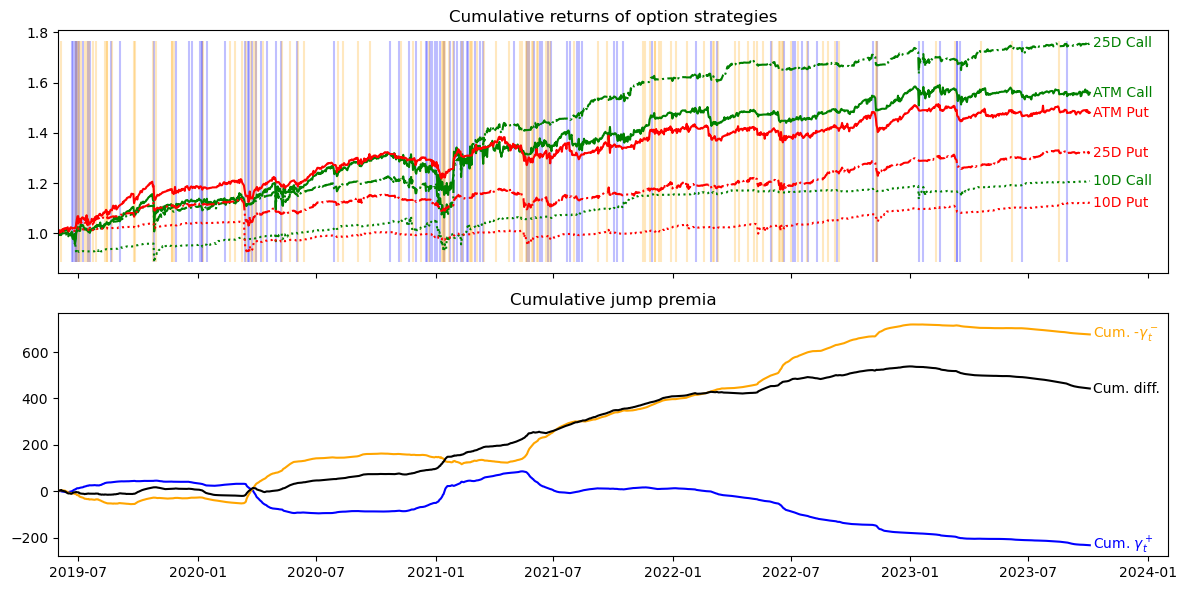

In [586]:
fig, ax = plt.subplots(2,1,figsize=(12, 6), sharex=True)

ymax = -1000
ymin =  1000

for portfolio in portfolios:
    
    f = f_dict[portfolio] 
    
    portfolio_TS = f.loc[:, 'NAV USD']/f.loc[:,'NAV USD'][0]
    
    if portfolio.endswith('Call'):
        color = 'green'
    else:
        color = 'red'
        
    if portfolio.startswith('Short ATM'):
        linestyle = 'solid'
    elif portfolio.startswith('Short 10D'):
        linestyle = 'dotted'
    elif portfolio.startswith('Short 25D'):
        linestyle = 'dashdot'

    ax[0].text(portfolio_TS.index[-1]+datetime.timedelta(days=5), portfolio_TS.iloc[-1], portfolio.replace('Short ', ''), ha='left', va='center', color=color)
    ax[0].plot(portfolio_TS, color=color, linestyle=linestyle)
    
    if np.max(portfolio_TS) > ymax:
        ymax = np.max(portfolio_TS)
        
    if np.min(portfolio_TS) < ymin:
        ymin = np.min(portfolio_TS)
    
ax[0].vlines(merged_daily.loc[merged_daily.is_pos_jump == 1].index, ymin=ymin, ymax=ymax, color='blue', zorder=-10, alpha=0.25)
ax[0].vlines(merged_daily.loc[merged_daily.is_neg_jump == 1].index, ymin=ymin, ymax=ymax, color='orange', zorder=-10, alpha=0.25)
ax[0].set_xlim(portfolio_TS.index[0], portfolio_TS.index[-1]+datetime.timedelta(days=120))
ax[0].set_title('Cumulative returns of option strategies')

ax[1].plot(pjp.cumsum(), color='blue')
ax[1].text(pjp.index[-1]+datetime.timedelta(days=5), pjp.cumsum().iloc[-1], r'Cum. $\gamma^+_t$', ha='left', va='center', color='blue')
ax[1].plot(-njp.cumsum(), color='orange')
ax[1].text(njp.index[-1]+datetime.timedelta(days=5), -njp.cumsum().iloc[-1], r'Cum. -$\gamma^-_t$', ha='left', va='center', color='orange')

ax[1].plot(pjp.cumsum()-njp.cumsum(), color='black')
ax[1].text(njp.index[-1]+datetime.timedelta(days=5), pjp.cumsum().iloc[-1]-njp.cumsum().iloc[-1], r'Cum. diff.', ha='left', va='center', color='black')

ax[1].set_title('Cumulative jump premia')
plt.tight_layout()
plt.savefig('optionstrategies_cum_returns.pdf', transparent=True, bbox_inches='tight')

In [718]:
results = dict()
for portfolio in portfolios:
    _data_for_regression = f_dict[portfolio].copy()
    _data_for_regression.r = _data_for_regression.r.shift(-1)*10_000 
    _data_for_regression.change = _data_for_regression.change.shift(-1)
    _data_for_regression.gain = _data_for_regression.gain.shift(-1)
    
    _data_for_regression.loc[:, 'pj_times_BSgamma'] = _data_for_regression.is_pos_jump * _data_for_regression.gamma
    _data_for_regression.loc[:, 'nj_times_BSgamma'] = _data_for_regression.is_neg_jump * _data_for_regression.gamma
    
    _data_for_regression = _data_for_regression - _data_for_regression.shift(1)
    _data_for_regression = _data_for_regression.loc[_data_for_regression.isna().sum(axis=1)==0]

    r = OLS(_data_for_regression.loc[:, 'r'], _data_for_regression.loc[:,['pjp', 'njp', 'theta', 'delta', 'gamma', 'is_pos_jump', 'is_neg_jump']]).fit()

    _params = r.params.index    
    print(portfolio)
    l = int(len(_data_for_regression)**.25) # Greene (Econometric Analysis, 7th edition, section 20.5.2, p. 960).
    print('lag=%i'%l)
    r = r.get_robustcov_results(cov_type='HAC', maxlags=l, use_correction=True)
    r.params = pd.Series(r.params, index = _params)
    results[portfolio] = r

Short ATM Call
lag=6
Short 10D Call
lag=6
Short 25D Call
lag=6
Short ATM Put
lag=6
Short 10D Put
lag=6
Short 25D Put
lag=6


In [719]:
from toolz import interleave
def make_table(r):
    r_table = pd.DataFrame(interleave([r.params, r.tvalues]))
    tuples = []

    for _id in r.params.index:
        for type in ['params', 'tvalues']:
            tuples.append((_id, type))
        
    index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
    r_table.index = index
    
    return r_table

In [720]:
table = pd.concat([make_table(results[portfolio]) for portfolio in portfolios], axis=1)
table.index = table.index.get_level_values('first')
table.columns = portfolios

new_index = []
for i, _id in enumerate(list(table.index)):
    if i%2==0:
        new_index.append(_id)
    else:
        new_index.append('')
        
table.index = new_index
# table = table.apply(lambda x: np.round(x, 4))
table = table.fillna('')

# add stars
for i in range(len(table)):
    if i%2==1:
        for j in range(len(table.iloc[i])):
            t = table.iloc[i].iloc[j]
            if t != '':
                p = (1-stats.t.cdf(np.abs(t), df = r.nobs))*2
                if p <= 0.01:
                    # print(i-1, j)
                    table.iloc[i-1,j] = '%.4f'%(table.iloc[i-1].iloc[j])+'(***)'
                elif p <= 0.05:
                    # print(i-1, j)
                    table.iloc[i-1,j] = '%.4f'%(table.iloc[i-1].iloc[j])+'(**)'
                elif p <= 0.1:
                    # print(i-1, j)
                    table.iloc[i-1,j] = '%.4f'%(table.iloc[i-1].iloc[j])+'(*)'
                else:
                    table.iloc[i-1,j] = '%.4f'%(table.iloc[i-1].iloc[j])


In [721]:
for i in range(len(table)):
    if i%2==1:
        for j in range(len(table.iloc[i])):
            t = table.iloc[i].iloc[j]
            if t != '':
                table.iloc[i, j] = '(%.4f)'%table.iloc[i, j]


In [722]:
table

,Short ATM Call,Short 10D Call,Short 25D Call,Short ATM Put,Short 10D Put,Short 25D Put
pjp,30.4223(**),23.4689(**),36.5286(***),0.9994,2.0545,-0.0992
,(2.2444),(2.2724),(2.9016),(0.1372),(0.7041),(-0.0197)
njp,-21.7878(*),-2.1590,-22.8817(**),-11.6210,-14.7701(***),-14.2850(***)
,(-1.7632),(-0.4590),(-1.9677),(-1.3853),(-3.3900),(-2.5808)
theta,-0.0001,0.0010,0.0024,0.0009,0.0036(***),0.0025(***)
,(-0.0773),(0.7021),(1.0282),(0.8950),(3.4379),(3.2651)
delta,-0.0483,-0.0366,-0.0812,0.0265,-0.2819(*),-0.0296
,(-1.1195),(-0.3320),(-1.1496),(0.7078),(-1.7357),(-0.4290)
gamma,71.5236,131.7541,407.3279(**),89.3677,-53.5989,75.9448
,(0.9699),(1.2030),(2.4086),(1.5824),(-0.2448),(1.4378)


In [695]:
R2_text = ' & '.join(['%.4f'%results[portfolio].rsquared_adj for portfolio in portfolios])
R2_text

'0.0244 & 0.0598 & 0.0815 & 0.0332 & 0.1559 & 0.0576'

In [723]:

latex = table.to_latex(index=True)
latex = latex.replace('()', '')

latex = latex.replace('pjp', '$\\gamma^+_t$')
latex = latex.replace('njp', '$\\gamma^-_t$')

latex = latex.replace('(*)', '$*$')
latex = latex.replace('(**)', '$**$')
latex = latex.replace('(***)', '$***$')

latex = latex.replace('lllllll', 'rSSSSSS')

latex = latex.replace('\\bottomrule',
                      '\\midrule\nAdj. $R^2$ & '
                      + R2_text + '\\\\' + '\\bottomrule')

latex = latex.replace('is\_pos\_jump', '$N^{(1)}_t - N^{(1)}_{t-7}$')
latex = latex.replace('is\_neg\_jump', '$N^{(2)}_t - N^{(2)}_{t-7}$')

latex = latex.replace('theta', 'BS theta')
latex = latex.replace('delta', 'BS delta')
latex = latex.replace('gamma ', 'BS gamma')


for portfolio in portfolios:
    latex = latex.replace(portfolio, '{' + portfolio + '}')


latex = latex.replace('Short ', '')

print(latex)


if short:
    with open('regression_on_Short_option_strategies_with_Greeks.tex', 'w') as f:
        f.write(latex)

else:
    with open('regression_on_Long_option_strategies_wth_Greeks.tex', 'w') as f:
        f.write(latex)

\begin{tabular}{rSSSSSS}
\toprule
{} & {ATM Call} & {10D Call} & {25D Call} & {ATM Put} &  {10D Put} &  {25D Put} \\
\midrule
$\gamma^+_t$         &    30.4223$**$ &    23.4689$**$ &   36.5286$***$ &        0.9994 &         2.0545 &        -0.0992 \\
            &       (2.2444) &       (2.2724) &       (2.9016) &      (0.1372) &       (0.7041) &      (-0.0197) \\
$\gamma^-_t$         &    -21.7878$*$ &        -2.1590 &   -22.8817$**$ &      -11.6210 &  -14.7701$***$ &  -14.2850$***$ \\
            &      (-1.7632) &      (-0.4590) &      (-1.9677) &     (-1.3853) &      (-3.3900) &      (-2.5808) \\
BS theta       &        -0.0001 &         0.0010 &         0.0024 &        0.0009 &    0.0036$***$ &    0.0025$***$ \\
            &      (-0.0773) &       (0.7021) &       (1.0282) &      (0.8950) &       (3.4379) &       (3.2651) \\
BS delta       &        -0.0483 &        -0.0366 &        -0.0812 &        0.0265 &     -0.2819$*$ &        -0.0296 \\
            &      (-1.1195) &      (-

In [724]:
table

,Short ATM Call,Short 10D Call,Short 25D Call,Short ATM Put,Short 10D Put,Short 25D Put
pjp,30.4223(**),23.4689(**),36.5286(***),0.9994,2.0545,-0.0992
,(2.2444),(2.2724),(2.9016),(0.1372),(0.7041),(-0.0197)
njp,-21.7878(*),-2.1590,-22.8817(**),-11.6210,-14.7701(***),-14.2850(***)
,(-1.7632),(-0.4590),(-1.9677),(-1.3853),(-3.3900),(-2.5808)
theta,-0.0001,0.0010,0.0024,0.0009,0.0036(***),0.0025(***)
,(-0.0773),(0.7021),(1.0282),(0.8950),(3.4379),(3.2651)
delta,-0.0483,-0.0366,-0.0812,0.0265,-0.2819(*),-0.0296
,(-1.1195),(-0.3320),(-1.1496),(0.7078),(-1.7357),(-0.4290)
gamma,71.5236,131.7541,407.3279(**),89.3677,-53.5989,75.9448
,(0.9699),(1.2030),(2.4086),(1.5824),(-0.2448),(1.4378)
